<a href="https://colab.research.google.com/github/gautumsvp7/LiarDataSet/blob/main/LiarDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving test.tsv to test.tsv
Saving train.tsv to train.tsv
Saving valid.tsv to valid.tsv


In [45]:
import pandas as pd

In [46]:
import io
tsk = pd.read_csv(io.BytesIO(uploaded['train.tsv']), sep='\t')

Description of the TSV format:

Column 1: the ID of the statement ([ID].json).

Column 2: the label.

Column 3: the statement.

Column 4: the subject(s).

Column 5: the speaker.

Column 6: the speaker's job title.

Column 7: the state info.

Column 8: the party affiliation.

Column 9-13: the total credit history count, including the current statement.

9: barely true counts.

10: false counts.

11: half true counts.

12: mostly true counts.

13: pants on fire counts.

Column 14: the context (venue / location of the speech or statement).


In [47]:
def read_dataframe(tsv_file: str) -> pd.DataFrame:
    
    # creates a "dataframe" or "df" for short. This is similar to a 2-D python dict.
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)
    
    # replaces all "null" or "NaN" values with an empty string
    df.fillna("", inplace=True)
    
    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.
        
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]
    
    return df

#create a dataframe from the training data
df = read_dataframe('train.tsv')

In [48]:
df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 10239 non-null  object
 1   label              10239 non-null  object
 2   statement          10239 non-null  object
 3   subjects           10239 non-null  object
 4   speaker            10239 non-null  object
 5   speaker_job_title  10239 non-null  object
 6   state_info         10239 non-null  object
 7   party_affiliation  10239 non-null  object
 8   count_1            10239 non-null  object
 9   count_2            10239 non-null  object
 10  count_3            10239 non-null  object
 11  count_4            10239 non-null  object
 12  count_5            10239 non-null  object
 13  context            10239 non-null  object
dtypes: object(14)
memory usage: 1.1+ MB


In [50]:
def print_row(input_df: pd.DataFrame, index: int) -> None:
    """Most relevant columns for today's analysis"""
    print(f"speaker: {input_df.iat[index, 4]}")
    print(f"subject(s): {input_df.iat[index, 3]}")
    print(f"statement: {input_df.iat[index, 2]}")
    print(f"label: {input_df.iat[index, 1]}")

print_row(df,1)

speaker: barack-obama
subject(s): foreign-policy
statement: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
label: mostly-true


## Exploratory Data analysis

These definitions were taken from PolitiFact's "truth-o-meter" methodology page

true – The statement is accurate and there’s nothing significant missing.

mostly-true – The statement is accurate but needs clarification or additional information.

half-true – The statement is partially accurate but leaves out important details or takes things out of context.

barely-true – The statement contains an element of truth but ignores critical facts that would give a different impression.

false – The statement is not accurate.

pants-fire – The statement is not accurate and makes a ridiculous claim. a.k.a. "Liar, Liar, Pants on Fire!"

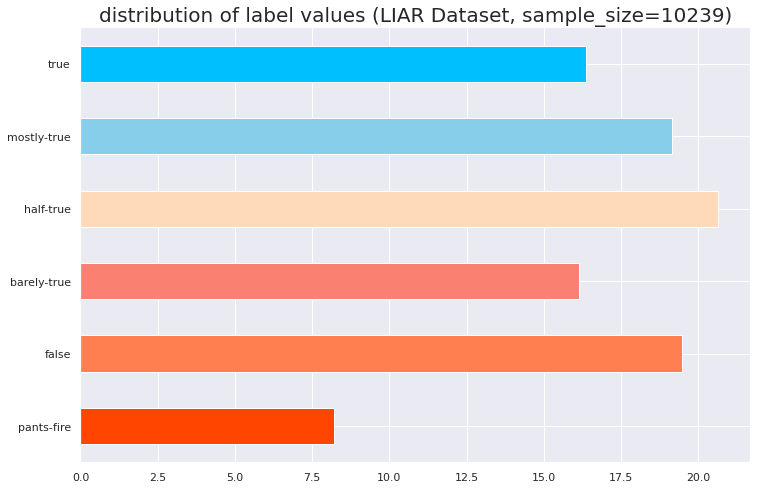

In [51]:
import seaborn as sns 
sns.set()


def label_bar_chart(input_df: pd.DataFrame, title: str = "LIAR Dataset") -> None:
    
    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df['label'].value_counts(normalize=True)
    
    def multiply_100(x):
        return x * 100
    
    # "apply" is a handy way to call a function on every row of data.
    label_frequencies = label_frequencies.apply(multiply_100)
    
    # bar chart ordering and  colors for readability.
    labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
    colors = [
        'orangered', # pants-fire
        'coral', # false
        'salmon', # barely-true
        'peachpuff', # half-true
        'skyblue', # mostly-true
        'deepskyblue' # true
    ]
    
    label_frequencies = label_frequencies.reindex(index = labels)
    
    
    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(12, 8), color=colors)
    axis.set_title(f"distribution of label values ({title}, sample_size={len(input_df)})", size=20);
    

# create bar chart over labels for the entire LIAR dataset.
label_bar_chart(df)

In [52]:
num_unique_speakers = df['speaker'].nunique()
avg_statments = len(df) / num_unique_speakers

print(f"Unique speakers in dataset: {num_unique_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in dataset: 2910
Average statements made per speaker: 3.5185567010309278


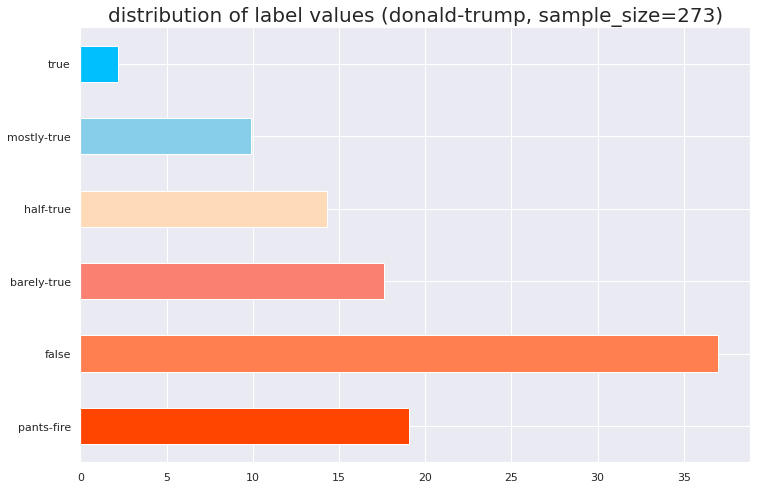

In [53]:
def speaker_bar_chart(input_df: pd.DataFrame, speaker: str) -> pd.DataFrame:
    
    # filters the input_df
    speaker_df = input_df[ input_df['speaker'] == speaker ]
    speaker_df.reset_index(inplace=True)
    
    # calls the bar chart function we created earlier
    label_bar_chart(speaker_df, title=speaker)
    
    return speaker_df
    

# create a bar chart over labels for a single speaker. Store the returned dataframe to a variable.
ret_df = speaker_bar_chart(df, 'donald-trump')

In [54]:
# this creates a new dataframe that only contains the label and subjects columns.
subject_df = df[['label', 'subjects']].copy()

# # start by turning the comma-separated values into a list of values
def csv_to_list(x):
    return x.split(",")

subject_df['subjects'] = subject_df['subjects'].apply(csv_to_list)

subject_df = subject_df.explode('subjects')

subject_df.head()

,label,subjects
0,half-true,energy
0,half-true,history
0,half-true,job-accomplishments
1,mostly-true,foreign-policy
2,false,health-care


In [55]:
subject_df.info

<bound method DataFrame.info of              label             subjects
0        half-true               energy
0        half-true              history
0        half-true  job-accomplishments
1      mostly-true       foreign-policy
2            false          health-care
...            ...                  ...
10236    half-true      social-security
10237        false              florida
10237        false       foreign-policy
10238   pants-fire          health-care
10238   pants-fire             veterans

[22204 rows x 2 columns]>

In [56]:
num_unique_subjects = subject_df['subjects'].nunique()

print(f"Unique subjects in dataset: {num_unique_subjects}")

Unique subjects in dataset: 143


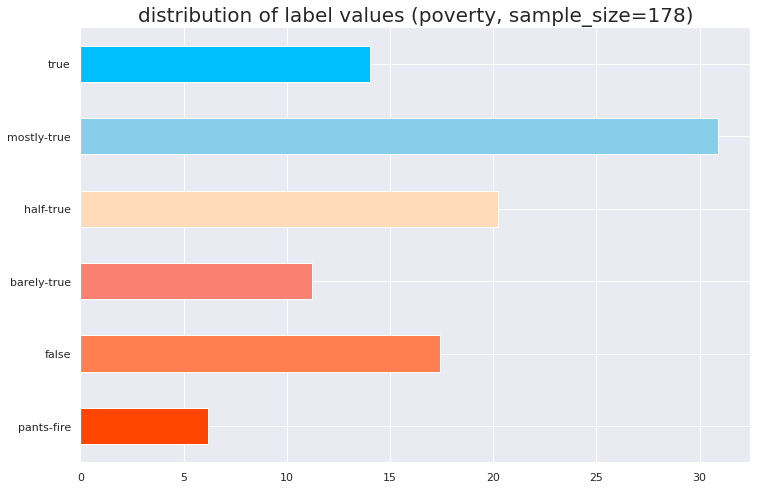

In [57]:
# 'energy', 'poverty', 'taxes', 'climate-change', 'obama-birth-certificate'
# list(subject_df['subjects'].unique())

def subject_bar_chart(input_df: pd.DataFrame, subject: str) -> pd.DataFrame:
    
    # filters the input_df
    ret_df = input_df[ input_df['subjects'] == subject ]
    ret_df.reset_index(inplace=True)
    
    # calls the bar chart function we created earlier
    label_bar_chart(ret_df, title=subject)
    
    return ret_df
    

# create a bar chart over labels for a single subject. Store the returned dataframe to a variable.
ret_df = subject_bar_chart(subject_df, 'poverty')

In [58]:
df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece


In [59]:
y_test = pd.read_csv(io.BytesIO(uploaded['test.tsv']), sep='\t')

# Sentiment Analysis

In [60]:
from typing import Dict


def score_label(label: str) -> float:
    scores = {
        'true': 2,
        'mostly-true': 1,
        'half-true': 0,
        'barely-true': -1,
        'false': -2,
        'pants-fire': -3
    }
    return scores[label]


def model_speaker_statements(input_df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    
    tot = {}
    count = {}
    
    # for each row in the input_df
    for _, row in input_df.T.items():
        
        # grab the pertinent information
        speaker = row['speaker']
        score = score_label(row['label'])
        words = row['statement'].lower().split()
        
        # prevents double counting of words
        uniques = []
        
        for word in words:
            # if its a word we've already seen, skip processing
            if word in uniques:
                continue
                    
            uniques.append(word)
            
            if speaker in tot:
                if word in tot[speaker]:
                    tot[speaker][word] += score
                    count[speaker][word] += 1
                else:
                    tot[speaker][word] = score
                    count[speaker][word] = 1
                    
            else:
                tot[speaker] = {}
                tot[speaker][word] = score
                
                count[speaker] = {}
                count[speaker][word] = 1
                
    
    # compute averages and return model
    for speaker in tot:
        for word in tot[speaker]:
            tot[speaker][word] = tot[speaker][word] / count[speaker][word]
            
    return tot


def score_speaker_statement(model: Dict[str, Dict[str, float]], speaker: str, phrase: str) -> float:
        
    idx = 0
    score = 0
    for word in phrase.split():
        word = word.lower()
        
        if word in model[speaker]:
            score += model[speaker][word]
            idx += 1
            
    if not idx:
        return None
    
    return score / idx
                                        

def sentiment_speaker_statement(model: Dict[str, Dict[str, float]], speaker: str, phrase: str) -> str:

    score = score_speaker_statement(model, speaker, phrase)

    if score is None:
        return None
    
    if score <= 0:
        return False
    
    return True

In [61]:
from IPython.display import Image

# build a model from the liar dataset
model = model_speaker_statements(df)

**Testing the model**

In [62]:
outcome = sentiment_speaker_statement(model, 'joe-biden', "A new, independent study put out last week found that at least 55 of our largest corporations used various loopholes to pay zero federal income tax in 2020.")
print(f"Model outcome: {outcome}\n")

Image("../input/liarscreenshots/Screen Shot 2021-04-18 at 10.27.43 PM.png") # https://www.politifact.com/personalities/joe-biden/

Model outcome: True



In [63]:
y_test.head()

,11972.json,true,Building a wall on the U.S.-Mexico border will take literally years.,immigration,rick-perry,Governor,Texas,republican,30,30.1,42,23,18,Radio interview
0,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
1,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
2,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
3,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video
4,5962.json,true,Over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,1,2,1,1,0,a campaign website


# SVM

In [64]:
# this creates a new dataframe that only contains the label and subjects columns.
subject_df = df[['label', 'statement']].copy()

# # start by turning the comma-separated values into a list of values
def csv_to_list(x):
    return x.split(",")

subject_df['statement'] = subject_df['statement'].apply(csv_to_list)

subject_df = subject_df.explode('statement')

subject_df.head()

,label,statement
0,half-true,When did the decline of coal start? It started...
1,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
2,false,Health care reform legislation is likely to ma...
3,half-true,The economic turnaround started at the end of ...
4,true,The Chicago Bears have had more starting quart...


In [65]:
#import pandas as pd
#import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

NLTK Library has word_tokenize and sent_tokenize to easily break a stream of text into a list of words or sentences, respectively.

In [66]:
x = subject_df
x.head()

,label,statement
0,half-true,When did the decline of coal start? It started...
1,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
2,false,Health care reform legislation is likely to ma...
3,half-true,The economic turnaround started at the end of ...
4,true,The Chicago Bears have had more starting quart...


In [67]:
x['statement'].dropna(inplace=True)

In [68]:
x.info

<bound method DataFrame.info of              label                                          statement
0        half-true  When did the decline of coal start? It started...
1      mostly-true  Hillary Clinton agrees with John McCain "by vo...
2            false  Health care reform legislation is likely to ma...
3        half-true  The economic turnaround started at the end of ...
4             true  The Chicago Bears have had more starting quart...
...            ...                                                ...
10236    half-true   has meant that participants will retire with ...
10237        false  On lifting the U.S. Cuban embargo and allowing...
10238   pants-fire  The Department of Veterans Affairs has a manua...
10238   pants-fire   'Are you really of value to your community?' ...
10238   pants-fire                encouraging them to commit suicide.

[16493 rows x 2 columns]>

In [69]:
x['statement']=[entry.lower() for entry in x['statement']]

In [70]:
x.head()

,label,statement
0,half-true,when did the decline of coal start? it started...
1,mostly-true,"hillary clinton agrees with john mccain ""by vo..."
2,false,health care reform legislation is likely to ma...
3,half-true,the economic turnaround started at the end of ...
4,true,the chicago bears have had more starting quart...


In [71]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
x['statement'] = [word_tokenize(entry) for entry in x['statement']]

In [73]:
x.head()

,label,statement
0,half-true,"[when, did, the, decline, of, coal, start, ?, ..."
1,mostly-true,"[hillary, clinton, agrees, with, john, mccain,..."
2,false,"[health, care, reform, legislation, is, likely..."
3,half-true,"[the, economic, turnaround, started, at, the, ..."
4,true,"[the, chicago, bears, have, had, more, startin..."


In [74]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(x['statement']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    x.loc[index,'text_final'] = str(Final_words)

ValueError: ignored